# Lefties Vs. Righties

### Background
* A <a href="https://www.nejm.org/doi/full/10.1056/NEJM199104043241418">1991 study</a> alleged that left-handed humans (lefties) die, on average, <u>9 years</u> earlier than right-handed humans (righties). Oof!
* Here, we will leverage age distribution data to see if we can replicate this phenomenon on the basis of changing rates of left-handedness over time. 
* We will incorporate 2 datasets for our analysis: <a href="https://www.cdc.gov/nchs/nvss/mortality_tables.htm"> 1999 US death distribution data</a>, and rates of left-handedness from a <a href="https://pubmed.ncbi.nlm.nih.gov/1528408/">1992 study</a>.
* We'll explore this data to plot the rates of left-handedness as a function of age, and try to understand the effect of changing handedness on the mean death age of lefties.

<b>Key skills:</b> Pandas data cleaning and manipulation, bayesian probability and statistics, matplotlib data visualisation.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Load data
leftie_data_url = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
leftie_data = pd.read_csv(leftie_data_url)

### 1) Light Exploration

#### Understand handedness over time

Text(0, 0.5, 'Pct of people that are lefties')

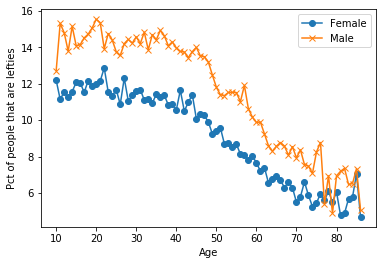

In [20]:
# Plot left-handedness rates vs. age, grouped by gender
%matplotlib inline
fig, ax = plt.subplots()
ax.plot('Age', 'Female', data = leftie_data, marker = 'o')
ax.plot('Age', 'Male', data = leftie_data, marker = 'x')
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Pct of people that are lefties")

#### Understand left-handedness over time

Text(0, 0.5, 'Pct left-handed')

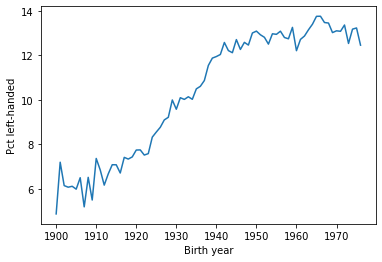

In [21]:
# Create a new "Birth_year" col
leftie_data['Birth_year'] = 1986 - leftie_data['Age']

# Create a new col for the average of male and female
leftie_data['Mean_lh'] = leftie_data[['Female', 'Male']].mean(axis=1)

# Plot new cols: 'Mean_lh' vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot('Birth_year', 'Mean_lh', data = leftie_data) # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel('Birth year')
ax.set_ylabel('Pct left-handed')

### 2) Applying Bayes Theorem

* The probability of dying at a certain age given left-handedness is NOT equal to the probability of being left-handed given dying at a given age. 
* This disparity demonstrates the need for <b>Bayes Theorem</b>, a theorem about conditional probability that allows us to update our beliefs following evidence.
* Here, we are interested in calculating the probability of dying at a given age, given that the person is a leftie. In other words, P(A|LH). 
* Similarly, we are interested in calculating P(A|RH).
* Here is the Bayes Theorem for left-handedness (LH) and dying at age A:

$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$


In [22]:
# Create a function for P(LH|A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    early_1900s_rate = leftie_data["Mean_lh"][-10:].mean() # Use mean of the 10 first points
    late_1900s_rate = leftie_data["Mean_lh"][:10].mean() # Use mean of the 10 last points

    middle_rates = leftie_data.loc[leftie_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # youngest age is 10
    oldest_age = study_year - 1986 + 86 # oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results

    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate/100
    P_return[ages_of_death < youngest_age] = late_1900s_rate/100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
    
    return P_return

Text(0, 0.5, 'Number of people who died')

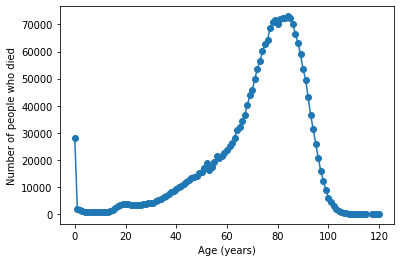

In [23]:
# Find P(A)
# Death distribution data for the United States in 1999
death_distribution_data_url = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# Load
death_distribution_data = pd.read_csv(death_distribution_data_url, sep='\t', skiprows=[1])

# Drop NaN values from `Both Sexes` col
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

# Plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o')
ax.set_xlabel('Age (years)') 
ax.set_ylabel('Number of people who died')

In [24]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year) # multiply number of dead people by P_lh_given_A
    p = p_list.sum() # calculate the sum of p_list
    return p/death_distribution_data['Both Sexes'].sum() # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

print(P_lh(death_distribution_data))

0.07766387615350638


#### Consolidating our work: calculating P(A|LH) and P(A|RH)

* At this stage, we've created functions to calculate the 3 quantities we need: P(A), P(LH), P(LH|A)
* We can combine these using the Bayes rule to get P(A|LH), which is the probabilty of being age A at death, given being a leftie.
* To make the result more meaningful, we'll also compare this to P(A|RH), which is the probability of being age A at death, given being a rightie.

In [25]:
# For lefties:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    P_A = death_distribution_data['Both Sexes'][ages_of_death]/death_distribution_data['Both Sexes'].sum()
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

In [26]:
# For righties:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    P_A = death_distribution_data['Both Sexes'][ages_of_death]/death_distribution_data['Both Sexes'].sum()
    P_right = 1-P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # P_rh_A = 1 - P_lh_A 
    return P_rh_A*P_A/P_right

### 3) Plotting distributions of the conditional probabilities
Now let's plot these probabilities for a range of ages of death e.g. 6-120 years old.

Text(0, 0.5, 'Probability of being age A at death')

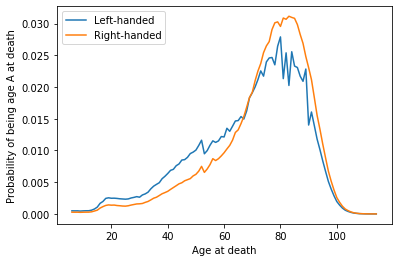

In [27]:
ages = np.arange(6, 115, 1) # make a list of ages of death to plot

# Calculate probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# Plot the two probabilities vs. age
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend() # add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

### 4) Finally, what is the age of lefties vs. righties at death?

* Finally, let's compare our results with the OG 1991 study which asserted that lefties died, on average, 9 years earlier than righties.
* To do this, we can calculate the mean of our probability distributions, weight the probability distribution by age, and sum the result:

$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$
$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$

In [28]:
# Calculate average ages for left-handed and right-handed groups
# (use np.array so that two arrays can be multiplied)
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# What are the average ages for each group
print(average_lh_age)
print(average_rh_age)



67.24503662801027
72.79171936526477


In [29]:
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 2)) + " years.")

The difference in average ages is -5.55 years.


### 5) Conclusions

* We observe a rather large age gap between lefties and righties, just based on the result of changing rates of left-handedness in the population.
* This likely means that humans won't die purely because of their handedness.
* Older humans are more likely to be reported as righties rather than as lefties (imbalance).
* Our reported difference is less than the 9 year difference reported by the 1991 study. Here are some possible reasons for this discrepancy:
    * Here we used 1999 death data while the OG study used 1991 death data.
    * We focussed on the US, while the 1991 study focussed on Californians.
    * Here we extrapolated left-handedness survey results for older and younger age groups. Perhaps these dont reflect the true rates.
    
Some suggestions for next steps:
* Use random sampling tools to understand how much variability we may expect in the death age difference due purely to random sampling.
* Leverage a newer dataset (e.g. 2020 death data) to understand current trends.

Thanks!